# 🤪 WGAN - CelebA Faces

In this notebook, we'll walk through the steps required to train your own Wasserstein GAN on the CelebA faces dataset

The code has been adapted from the excellent [WGAN-GP tutorial](https://keras.io/examples/generative/wgan_gp/) created by Aakash Kumar Nain, available on the Keras website.

In [1]:
%load_ext autoreload
%autoreload 2
import time
startTime=time.time()
import os #训练损失结果写入txt文件
import math

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import (
    layers,
    models,
    callbacks,
    utils,
    metrics,
    optimizers,
)

from notebooks.utils import display, sample_batch #书作者自编模块

## 0. Parameters <a name="parameters"></a>

In [2]:
IMAGE_SIZE =  (128, 512) #2023.11.20
CHANNELS = 1 #2023.11.20
BATCH_SIZE =  12 #2023.11.20,   GPU训练取16显存不足
train_dir=".\\png 512x128_GRAY\\"#2023.11.20。文件名字符数目不能过多，否则出错，故在旋转、缩放、平移变换时减少文件名字符。
steps_per_epoch=math.ceil(9600/BATCH_SIZE)  #2023.11.20。文件总数9600。math.ceil() 对浮点数向上取整。
Z_DIM =  2 #2023.11.20，高维没有意义
LEARNING_RATE = 0.0001 #2023.11.29,小BATCH_SIZE要减少学习率（原先是0.0002）。默认值是0.001
ADAM_BETA_1 = 0.4 #2023.11.29,原先是0.5。默认值是0.9
ADAM_BETA_2 = 0.9 #2023.11.29,原先是0.9。默认值是0.999
EPOCHS =  7 #2023.11.20，GPU训练EPOCHS=25;How many minute:414。CPU训练慢于GPU九倍。
CRITIC_STEPS = 5 #2023.12.07,原先是3
GP_WEIGHT = 20 #2023.12.07,原先是10。
"""
生成器输出tanh值(-1,1)，imshow函数是否能够正确显示图像？答：能够正确显示图像。

神经网络增加一层：最后一个conv2D输出（2, 8, 128），效果提升了，可见目前需要增加参数量。
神经网络再增加一层看看：最后一个conv2D输出（1, 4, 128），效果变差了，故维持不变
神经元数量增加：效果变差了，故维持不变。

增加epochs：取epochs=7图片质量即较好了（5~9轮较适合）。

维度参数：BATCH_SIZE=12时测试了3、4、8、64、512维，发现高维没什么意义，增加维度没有任何改善。

BATCH_SIZE=200时：64、8维并不比2维好，增加维度没有任何改善。64维生成图片质量反而降低了许多。

CRITIC_STEPS = 5，原先是3。结果：图像质量提高，增加耗时60%。

GP_WEIGHT = 20时，图片质量提升。

"""
#LOAD_MODEL =True #True表示在上次保存权重的结果上接着训练，False表示重新开始训练。如果修改了参数影响权重系统，那么就要从头训练。
LOAD_MODEL =False #GPU在上次保存权重的结果上接着训练出错（即使不退出笔记本也是），只能从头训练。CPU训练可以接着训练（退出后再进入也可）。

## 1. Prepare the data <a name="prepare"></a>

In [3]:
# Load the data
train_data = utils.image_dataset_from_directory(
    train_dir, #2023.11.20
    labels=None,
    color_mode="grayscale", #2023.11.20
    image_size=IMAGE_SIZE, #2023.11.20
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    interpolation="bilinear", #双线性插值
)

Found 9600 files belonging to 1 classes.


In [4]:
# Preprocess the data
def preprocess(img):
    """
    Normalize and reshape the images
    """
    img = (tf.cast(img, "float32") - 127.5) / 127.5 #tf.cast()函数：数据类型转换。这里将0~255转换为-1~1
    return img


train = train_data.map(lambda x: preprocess(x))

In [5]:
# Show some faces from the training set
train_sample = sample_batch(train)

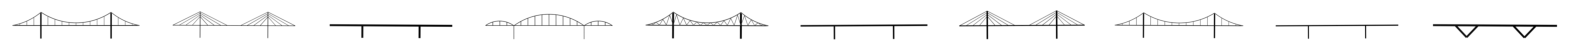

In [6]:
display(train_sample) #cmap="gray"为原始图灰度（如黑底白字），="gray_r"为原始图的灰度反相（如黑底白字反转为白底黑字）

## 2. Build the WGAN-GP <a name="build"></a>

In [7]:
critic_input = layers.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], CHANNELS)) #2023.11.20，本段全部内容大调整
x = layers.Conv2D(64, kernel_size=4, strides=2, padding="same")(critic_input)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(128, kernel_size=4, strides=2, padding="same")(x)
x = layers.LeakyReLU()(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(128, kernel_size=4, strides=2, padding="same")(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(128, kernel_size=4, strides=2, padding="same")(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(128, kernel_size=4, strides=2, padding="same")(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(128, kernel_size=4, strides=2, padding="same")(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Flatten()(x) 
critic_output = layers.Dense(1)(x) #critic没有sigmoid激活函数，这是wgan的特点
critic = models.Model(critic_input, critic_output)
critic.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 512, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 256, 64)       1088      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 64, 256, 64)       0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 256, 64)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 128, 128)      131200    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 128, 128)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 128, 128)      0     

In [8]:
generator_input = layers.Input(shape=(Z_DIM,)) #2023.11.20，本段全部内容大调整
x = layers.Dense(2 * 8 * 128)(generator_input)
x = layers.Reshape((2, 8, 128))(x)
x = layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same")(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same")(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same")(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same")(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2DTranspose(64, kernel_size=4, strides=2, padding="same")(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
generator_output = layers.Conv2DTranspose(CHANNELS, kernel_size=4, strides=2, padding="same", activation="tanh")(x) #tanh值(-1,1)
generator = models.Model(generator_input, generator_output)
generator.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2048)              6144      
_________________________________________________________________
reshape (Reshape)            (None, 2, 8, 128)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 4, 16, 128)        262272    
_________________________________________________________________
batch_normalization (BatchNo (None, 4, 16, 128)        512       
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 4, 16, 128)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 4, 16, 128)        0   

In [9]:
class WGANGP(models.Model):
    def __init__(self, critic, generator, latent_dim, critic_steps, gp_weight):
        super(WGANGP, self).__init__()
        self.critic = critic
        self.generator = generator
        self.latent_dim = latent_dim
        self.critic_steps = critic_steps
        self.gp_weight = gp_weight

    def compile(self, c_optimizer, g_optimizer):
        super(WGANGP, self).compile()
        self.c_optimizer = c_optimizer
        self.g_optimizer = g_optimizer
        self.c_wass_loss_metric = metrics.Mean(name="c_wass_loss")
        self.c_gp_metric = metrics.Mean(name="c_gp")
        self.c_loss_metric = metrics.Mean(name="c_loss")
        self.g_loss_metric = metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [
            self.c_loss_metric,
            self.c_wass_loss_metric,
            self.c_gp_metric,
            self.g_loss_metric,
        ]

    def gradient_penalty(self, batch_size, real_images, fake_images): #WGAN-GP中的梯度惩罚项，见《生成式深度学习第一版》P134~135
        alpha = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0) #0.0为正态分布的均值，1.0为正态分布的标准差
        diff = fake_images - real_images
        interpolated = real_images + alpha * diff #真假图像之间的插值

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            pred = self.critic(interpolated, training=True)

        grads = gp_tape.gradient(pred, [interpolated])[0]
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp

    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]

        for i in range(self.critic_steps):
            random_latent_vectors = tf.random.normal(
                shape=(batch_size, self.latent_dim)
            )

            with tf.GradientTape() as tape:
                fake_images = self.generator(
                    random_latent_vectors, training=True #是不是training=False才好?即让dropout层不工作？答：效果不好
                )
                fake_predictions = self.critic(fake_images, training=True) #training=True让dropout层工作，见《python深度学习》P168
                real_predictions = self.critic(real_images, training=True)

                c_wass_loss = tf.reduce_mean(fake_predictions) - tf.reduce_mean(
                    real_predictions
                )
                c_gp = self.gradient_penalty(
                    batch_size, real_images, fake_images
                )
                c_loss = c_wass_loss + c_gp * self.gp_weight #例如- c_loss: -101.2830 - c_wass_loss: -170.0919 - c_gp: 6.8809 - g_loss: -236.3423，则c_loss = c_wass_loss + c_gp * self.gp_weight=-170.0919+6.8809*10=-101.2830

            c_gradient = tape.gradient(c_loss, self.critic.trainable_variables)#.trainable_variables与.trainable weights（见《python深度学习》P168）是相同的功能
            self.c_optimizer.apply_gradients(
                zip(c_gradient, self.critic.trainable_variables)
            )

        random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim)
        )
        with tf.GradientTape() as tape:
            fake_images = self.generator(random_latent_vectors, training=True)
            fake_predictions = self.critic(fake_images, training=True) #是不是training=False才好?即让dropout层不工作？答：效果不好
            g_loss = -tf.reduce_mean(fake_predictions)

        gen_gradient = tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(
            zip(gen_gradient, self.generator.trainable_variables)
        )

        self.c_loss_metric.update_state(c_loss)
        self.c_wass_loss_metric.update_state(c_wass_loss)
        self.c_gp_metric.update_state(c_gp)
        self.g_loss_metric.update_state(g_loss)

        return {m.name: m.result() for m in self.metrics}

In [10]:
# Create a GAN
wgangp = WGANGP(
    critic=critic,
    generator=generator,
    latent_dim=Z_DIM,
    critic_steps=CRITIC_STEPS,
    gp_weight=GP_WEIGHT,
)

In [11]:
if LOAD_MODEL:
    wgangp.load_weights("./checkpoint/checkpoint.ckpt")

## 3. Train the GAN <a name="train"></a>

In [12]:
# Compile the GAN
wgangp.compile(
    c_optimizer=optimizers.Adam(
        learning_rate=LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2
    ),
    g_optimizer=optimizers.Adam(
        learning_rate=LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2
    ),
)

In [13]:
# Create a model save checkpoint
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint/checkpoint.ckpt",
    save_weights_only=True,
    save_freq="epoch",
    verbose=0,
)

tensorboard_callback = callbacks.TensorBoard(log_dir="./logs") #可以调用tensorboard察看损失曲线


class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img, latent_dim):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(
            shape=(self.num_img, self.latent_dim)
        )
        generated_images = self.model.generator(random_latent_vectors)
        generated_images = generated_images * 127.5 + 127.5 #因为tanh值(-1,1)
        generated_images = generated_images.numpy()
        display(
            generated_images,
            n=self.num_img,  #2023.11.30
            size=(160, 2),   #2023.11.30        
            save_to="./output/generated_img_%03d.png" % (epoch),
            #cmap=None, #2023.11.20
        )
        generator.save("./output/generator_epoch%d.h5"%epoch) #2023.11.30每轮输出模型

Epoch 1/7
800/800 [==============================] - 988s 1s/step - c_loss: -68.4479 - c_wass_loss: -103.1327 - c_gp: 1.7342 - g_loss: -115.8006

Saved to ./output/generated_img_000.png


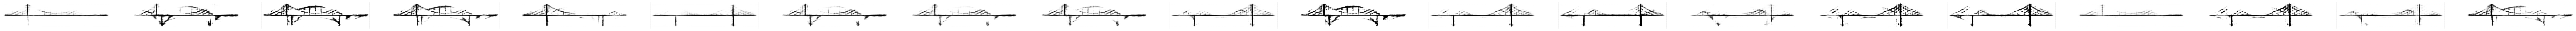

Epoch 2/7
800/800 [==============================] - 976s 1s/step - c_loss: -19.9601 - c_wass_loss: -23.9862 - c_gp: 0.2013 - g_loss: -31.2744

Saved to ./output/generated_img_001.png


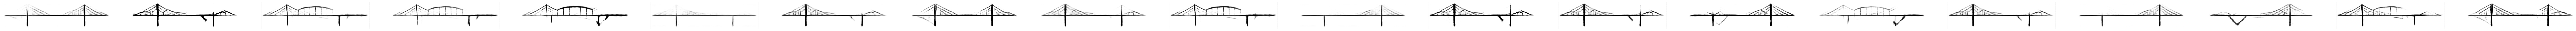

Epoch 3/7
800/800 [==============================] - 979s 1s/step - c_loss: -23.2403 - c_wass_loss: -27.3971 - c_gp: 0.2078 - g_loss: -13.6210

Saved to ./output/generated_img_002.png


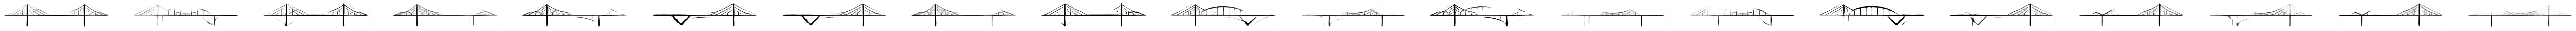

Epoch 4/7
800/800 [==============================] - 975s 1s/step - c_loss: -18.9788 - c_wass_loss: -22.6673 - c_gp: 0.1844 - g_loss: -37.0007

Saved to ./output/generated_img_003.png


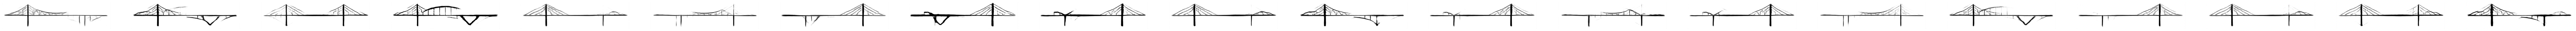

Epoch 5/7
800/800 [==============================] - 975s 1s/step - c_loss: -18.6826 - c_wass_loss: -22.0707 - c_gp: 0.1694 - g_loss: 19.7633

Saved to ./output/generated_img_004.png


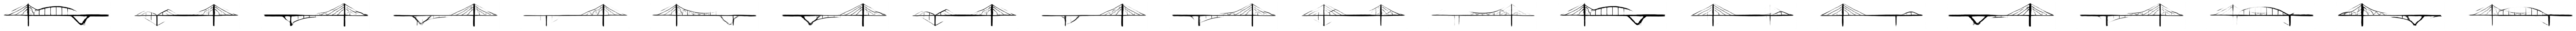

Epoch 6/7
800/800 [==============================] - 974s 1s/step - c_loss: -7.8885 - c_wass_loss: -11.0293 - c_gp: 0.1570 - g_loss: -37.9466

Saved to ./output/generated_img_005.png


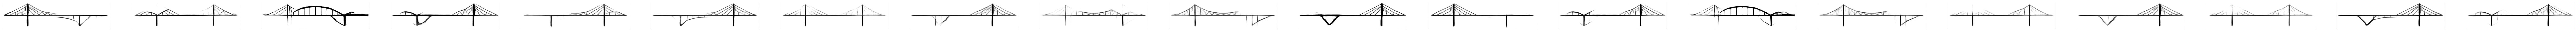

Epoch 7/7
800/800 [==============================] - 992s 1s/step - c_loss: -13.3980 - c_wass_loss: -15.8302 - c_gp: 0.1216 - g_loss: -33.6394

Saved to ./output/generated_img_006.png


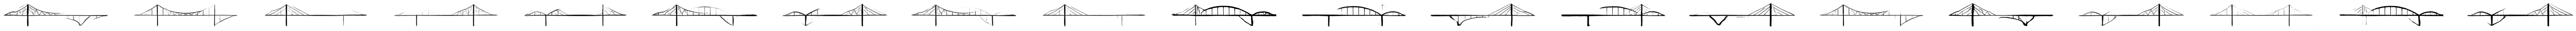

In [14]:
history=wgangp.fit(
    train,
    epochs=EPOCHS,
    steps_per_epoch=steps_per_epoch, #2023.11.20
    callbacks=[
        model_checkpoint_callback,
        tensorboard_callback,
        ImageGenerator(num_img=20, latent_dim=Z_DIM),  #2023.11.30，每轮输出20张图片
    ],
)

In [15]:
with open('history.history.txt', 'w') as file_object:file_object.write(str(history.history)+'\n')  #损失写入文件

In [16]:
# Save the final models
generator.save("./models/generator")
critic.save("./models/critic")

INFO:tensorflow:Assets written to: ./models/generator\assets
INFO:tensorflow:Assets written to: ./models/critic\assets


'\n经过查看，相近的不同批次的损失值如果有数量级的差别，才有少许可比性，能够大致确定图片质量。\n'

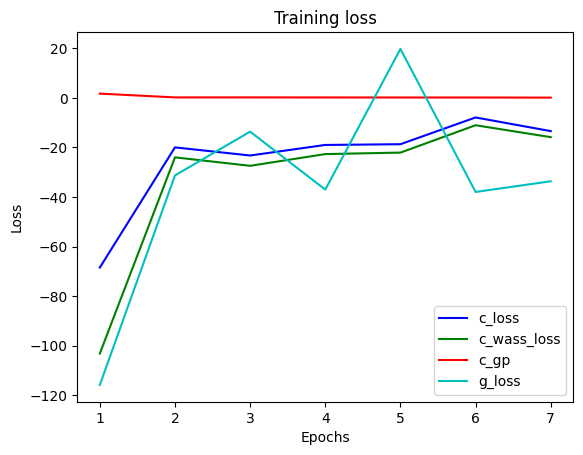

In [17]:
history_dict = history.history
c_loss = history_dict['c_loss']
c_wass_loss = history_dict['c_wass_loss']
c_gp = history_dict['c_gp']
g_loss = history_dict['g_loss']
epochs = range(1, len(c_loss) + 1)
plt.plot(epochs, c_loss, 'b', label='c_loss')
plt.plot(epochs, c_wass_loss, 'g', label='c_wass_loss')
plt.plot(epochs, c_gp, 'r', label='c_gp')
plt.plot(epochs, g_loss, 'c', label='g_loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
'''
经过查看，相近的不同批次的损失值如果有数量级的差别，才有少许可比性，能够大致确定图片质量。
'''


## Generate images

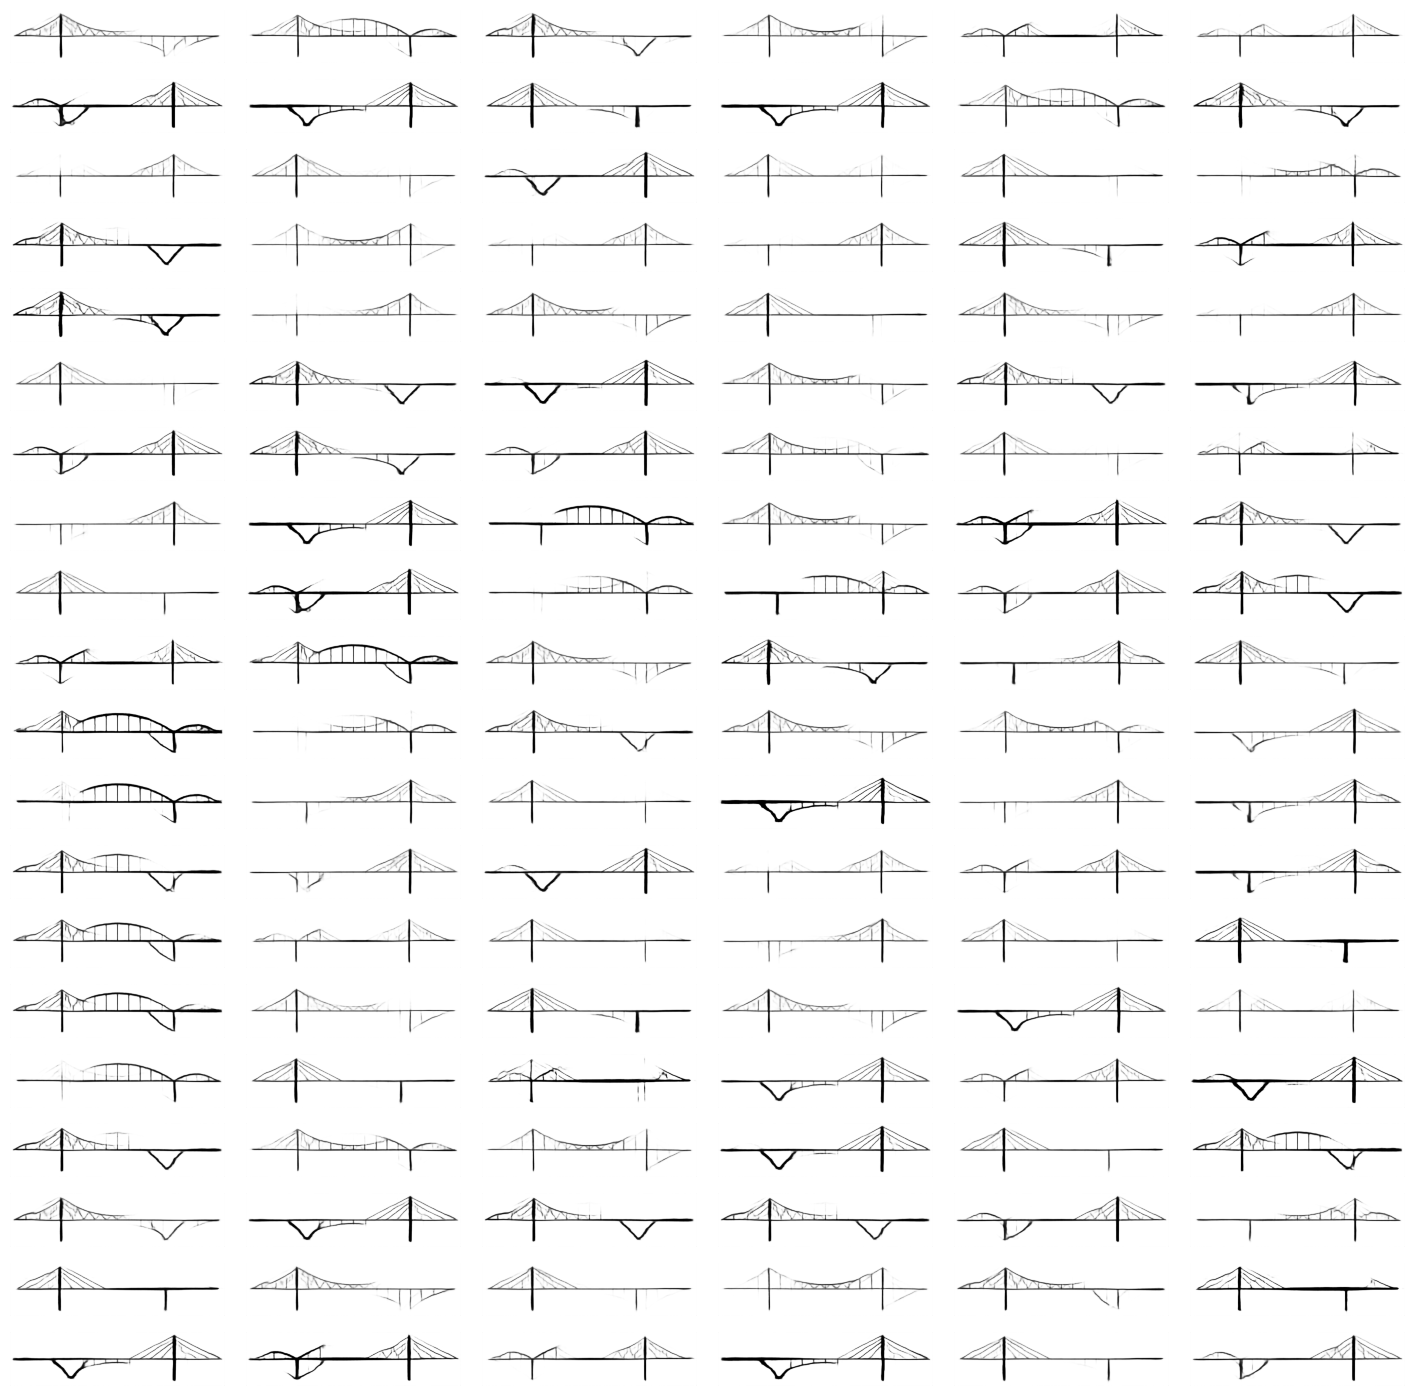

In [18]:
# Sample some points in the latent space, from the standard normal distribution
grid_width, grid_height = (6, 20)
z_sample = np.random.normal(size=(grid_width * grid_height, Z_DIM))

# Decode the sampled points
imgs = generator.predict(z_sample) #tanh值(-1,1),ax.imshow能够正确显示

# Draw a plot of decoded images
fig = plt.figure(figsize=(18, 18))
fig.subplots_adjust(hspace=0.1, wspace=0.1)

# Output the grid of faces
for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.imshow(imgs[i, :, :], cmap="Greys") #imshow参数有cmap、vmin、vmax。vmin和vmax指定颜色映射表范围，默认是数据中的最大和最小值

In [19]:
def compare_images(img1, img2):
    return np.mean(np.abs(img1 - img2))

In [20]:
all_data = []
for i in train.as_numpy_iterator(): #“.as_numpy_iterator()”是tf.data.Dataset类的方法，这里返回一个将数据元素转换为numpy的迭代器
    all_data.extend(i)
all_data = np.array(all_data) #得到全部的训练集数据
all_data.shape

(9600, 128, 512, 1)

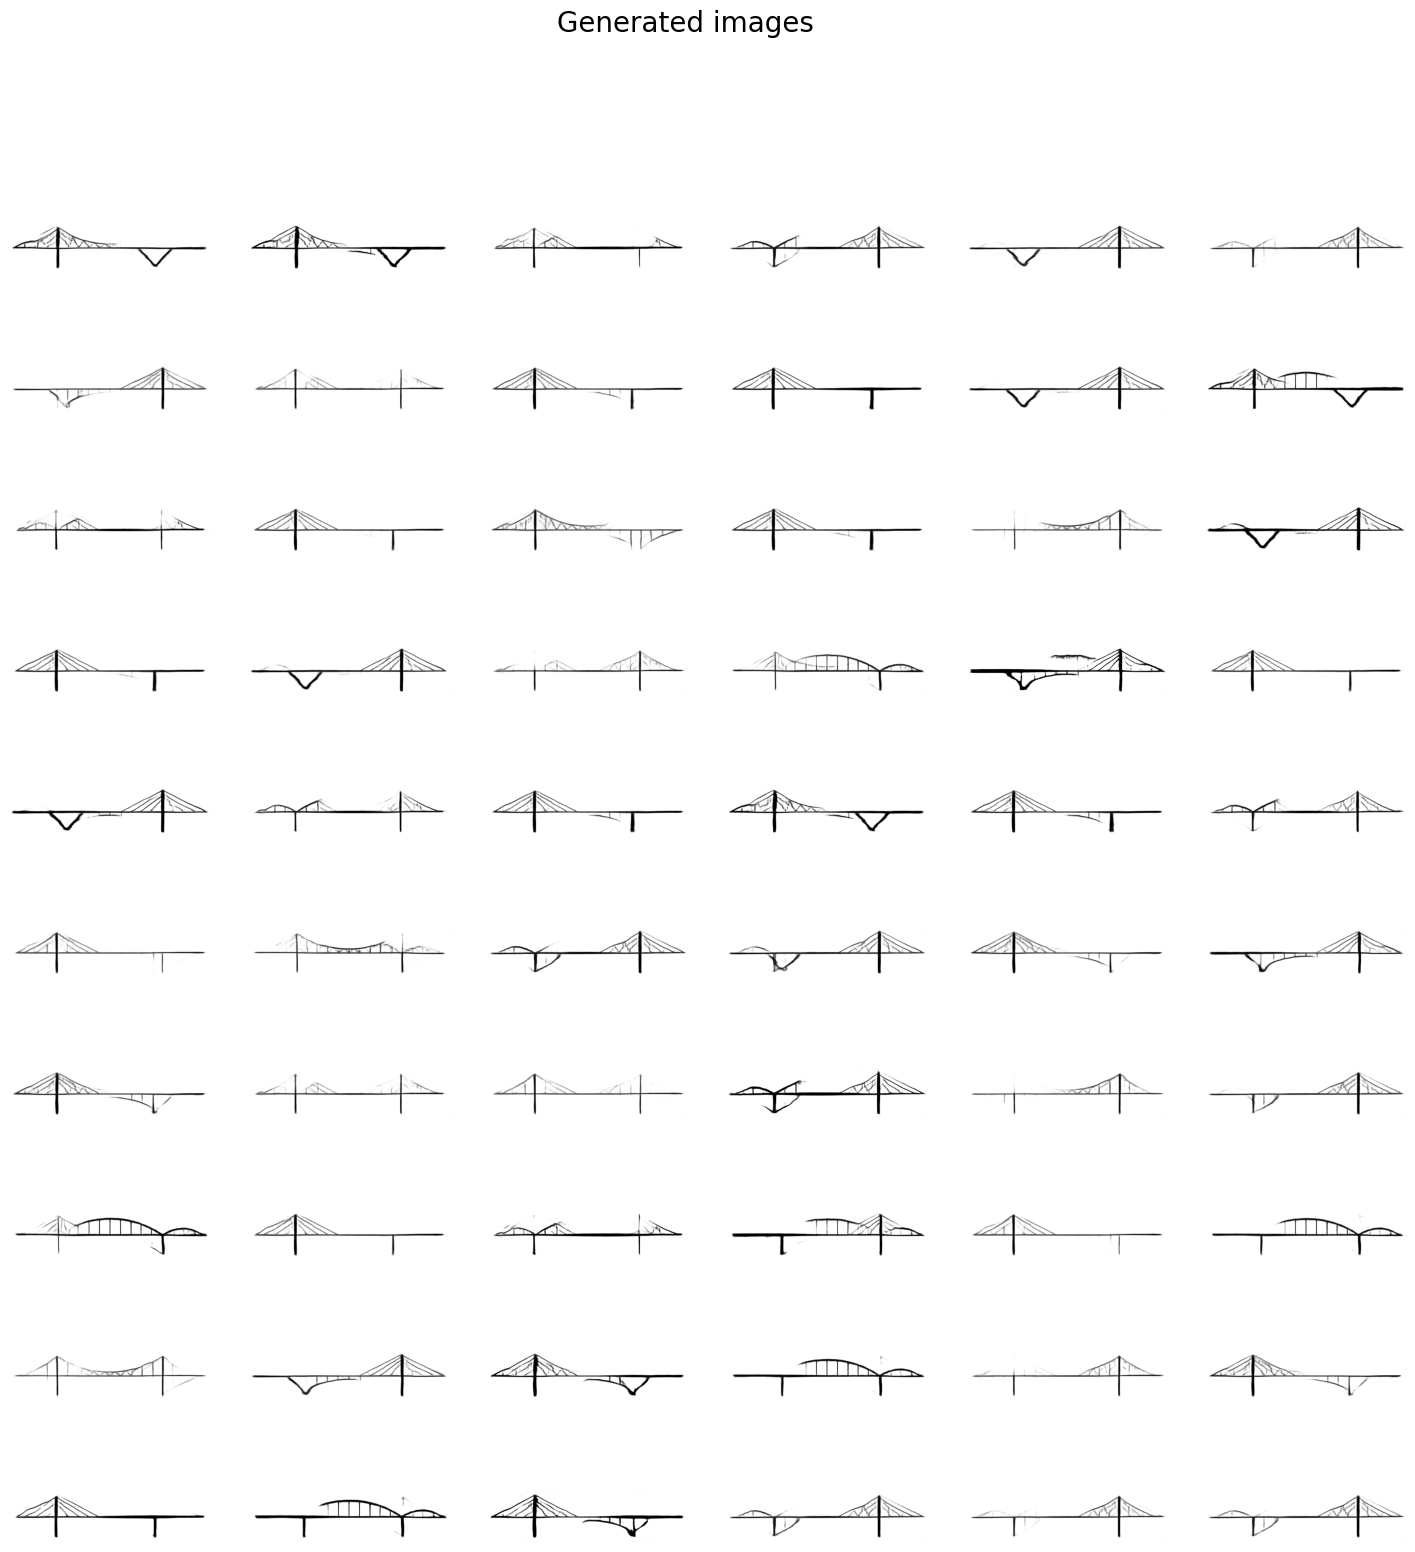

In [21]:
r, c = 10, 6
fig, axs = plt.subplots(r, c, figsize=(18, 18))
fig.suptitle("Generated images", fontsize=20)

noise = np.random.normal(size=(r * c, Z_DIM))
gen_imgs = generator.predict(noise)

cnt = 0
for i in range(r):
    for j in range(c):
        axs[i, j].imshow(gen_imgs[cnt], cmap="gray_r")
        axs[i, j].axis("off")
        cnt += 1

plt.show()

In [22]:
'''
fig, axs = plt.subplots(r, c, figsize=(18, 18))
fig.suptitle("Closest images in the training set", fontsize=20)

cnt = 0
for i in range(r):
    for j in range(c):
        c_diff = 99999
        c_img = None
        for k_idx, k in enumerate(all_data):
            diff = compare_images(gen_imgs[cnt], k)
            if diff < c_diff:
                c_img = np.copy(k)
                c_diff = diff
        axs[i, j].imshow(c_img, cmap="gray_r")
        axs[i, j].axis("off")
        cnt += 1

plt.show()
'''

'\nfig, axs = plt.subplots(r, c, figsize=(18, 18))\nfig.suptitle("Closest images in the training set", fontsize=20)\n\ncnt = 0\nfor i in range(r):\n    for j in range(c):\n        c_diff = 99999\n        c_img = None\n        for k_idx, k in enumerate(all_data):\n            diff = compare_images(gen_imgs[cnt], k)\n            if diff < c_diff:\n                c_img = np.copy(k)\n                c_diff = diff\n        axs[i, j].imshow(c_img, cmap="gray_r")\n        axs[i, j].axis("off")\n        cnt += 1\n\nplt.show()\n'

In [23]:
endTime=time.time()
print('EPOCHS=%d;How many minute:%d'%(EPOCHS,(endTime-startTime)/60)) 

EPOCHS=7;How many minute:114
